In [9]:
using JuMP, Gurobi

function simpleModel(N,M)
    T = N #upper bound on project completion

    #m = Model(solver=CbcSolver)
    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, x[1:N, 1:M, 1:T], Bin)
    @variable(m, last)

    # due to the following two constraints, this just selects the time
    # when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
    @expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

    # each task is only worked on once
    @constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

    # min { max_j end_t[j] }
    @constraint(m, [j=1:N], last >= start_t[j] + 1)

    @objective(m, Min, last)

    solve(m)
    timer = getsolvetime(m)
    return timer
end
                
function discreteTimeModel(N,M)
    # Task/Worker Parameters
    ###############################

    ## We require 5 of task_1, 1 of task_2, etc.
    n = maximum(N) #max number of tasks for a category
    v = size(N,1) # number of types of tasks

    ## Each row of W is a worker, and the column is the time required for the worker to complete that task
    w = size(W,1) #number of workers

    T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

    ###############################

    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
    @variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

    @variable(m, last)

    #If a worker starts a task at time t, z if true until the tasks completes
    for i=1:n
        for j=1:v
            for k=1:w
                for t=1:T
                    #@constraint(m, [i=1:n,j=1:v,k=1:w, t=1:T], z[i,j,k,t+l] == x[i,j,k,t] for l=1:W[k,j])
                    if t < T-convert(Int64,W[k,j])
                        @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                    else
                        @constraint(m, [l=1:T-t], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                    end
                end
            end
        end
    end

    #only one task in z can be worked simultaneously
    @constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

    #expression is used as an epigraph to find the end time of the last task
    @expression(m, end_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t+W[i,k]) for t=1:T))
    @expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))
    
    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)
    
    # each task is only worked on once and all tasks are completed
    @constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
    @constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])
    
    # min { max_j end_t[j] }
    @constraint(m, [j=1:n, k=1:v, i=1:w], last >= end_t[j,k,i])
    
    @objective(m, Min, last)    
    solve(m)
    timer = getsolvetime(m)
    return timer
end
                
function binaryTaskBundles(quotas, n_workers)
  
    # Task/Worker Parameters
    ###############################
    m_tasks = length(quotas)
    horizon = maximum(quotas)

    initial_task_lengths = rand(1:10, m_tasks)
    min_task_lengths = max.(1, initial_task_lengths - rand(1:10, m_tasks))
    task_bundle_times = [sum(max(min_task_lengths[j], initial_task_lengths[j]-t) for t in 1:T) for j in 1:m_tasks, T in 1:horizon]

    ###############################

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, work[1:n_workers, 1:m_tasks, 1:horizon], Bin)
    @variable(m, slowest_worker >= 0)

    @expression(m, work_on[j in 1:m_tasks], sum(work[i,j,t]*t for t in 1:horizon, i in 1:n_workers))

    # we must meet quotas
    @constraint(m, quota_constr[j in 1:m_tasks], work_on[j] >= quotas[j])

    # worker speed
    @expression(m, worker_speed[i in 1:n_workers],
        sum(sum(task_bundle_times[j, t] * work[i,j,t] for t in 1:horizon) for j in 1:m_tasks))

    for i in 1:n_workers, j in 1:m_tasks
        addSOS1(m, work[i,j,:])
    end

    # ∞-norm epigraph bounds for slowest_worker
    @constraints(m, begin
        worker_speed .<= slowest_worker
        -slowest_worker .<= worker_speed
    end)

    # minimize the amount of time the slowest worker takes
    @objective(m, Min, slowest_worker)
    
    solve(m)
    timer = getsolvetime(m)
    return timer
end

binaryTaskBundles (generic function with 1 method)

In [19]:
## have consistent scale factor and averages

scaleFactor = 20
averages = 5

5

## Model 1

5 workers, numnber of tasks ranges from 5 to 500

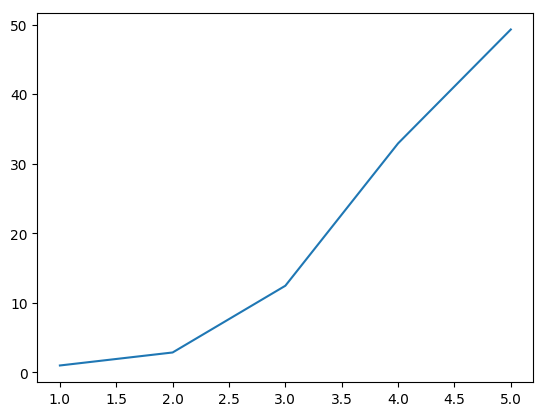

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [78]:
using JuMP, Gurobi, PyPlot

N = 5; M= 5 # task, worker, time inital values
#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        timer[u] = timer[u] + simpleModel(N*u,M)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 1

100 tasks, workers vary from 5 to 100


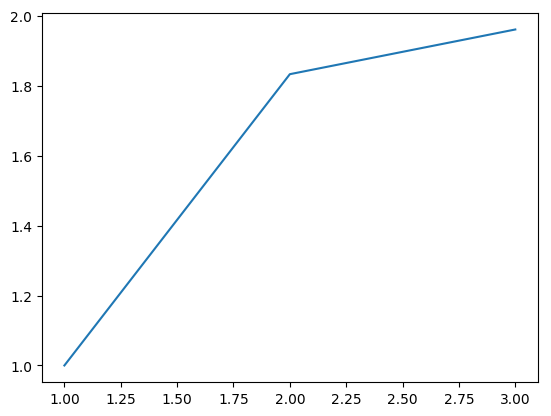

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
[1.0, 1.83291, 1.96074]


In [70]:
using JuMP, Gurobi, PyPlot

N = 50; M= 5 # task, worker, time inital values
#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        timer[u] = timer[u] + simpleModel(N,M*u,)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 2 - Tasks 

Number of workers and task types held constant

Total number of tasks scales

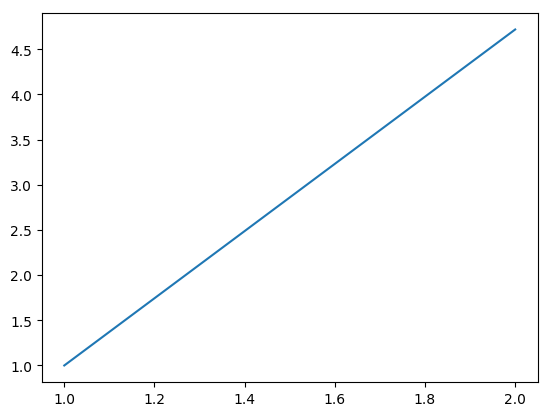

Academic license - for non-commercial use only
Academic license - for non-commercial use only
[1.0, 4.71833]


In [3]:
using JuMP, Gurobi, PyPlot

# task, worker values
N = rand(1:3,1,3)
W = rand(1:10,2,3)

#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        timer[u] = timer[u] + discreteTimeModel(N*u,W)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 2 - Workers

Number of tasks and types of tasks held constant.  

Number of workers scales

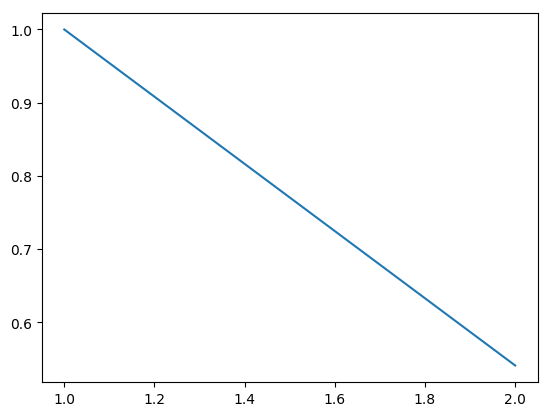

Academic license - for non-commercial use only
Academic license - for non-commercial use only
[1.0, 0.540959]


In [10]:
using JuMP, Gurobi, PyPlot

#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        # task, worker values
        N = rand(15:20,1,3)
        W = rand(1:10, 5*u,3)
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 2 - Task Variety
Number of workers and tasks held constant.

Variety of task types scales


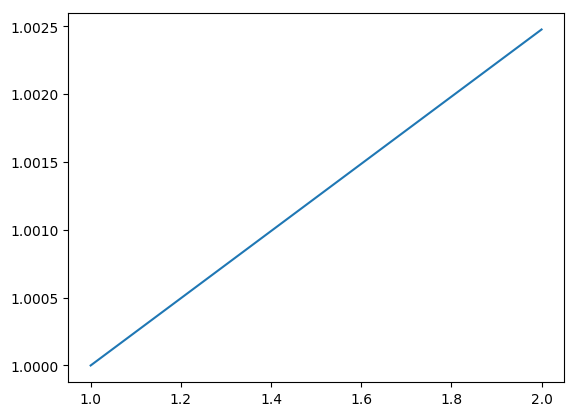

Academic license - for non-commercial use only
Academic license - for non-commercial use only
[1.0, 1.00248]


In [11]:
using JuMP, Gurobi, PyPlot, Cbc

#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        # task, worker values
        N = round.(Int, 50/u * ones(u))
        W = rand(1:10, 5,3)
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Model 2 - Task Variety, tasks number scales accordingly.
Number of workers constant

Variety of task types scales, and each task is done the same number of times.


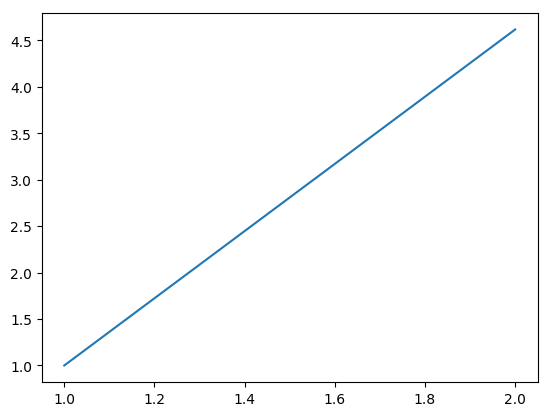

Academic license - for non-commercial use only
Academic license - for non-commercial use only
[1.0, 4.61799]


In [12]:
using JuMP, Gurobi, PyPlot, Cbc

#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        # task, worker values
        N = rand(8:12,1,u)
        W = rand(1:10, 5,3)
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Binary Task Bundles - Workers
n_tasks, quotas constant

n_workers is scaled

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
[

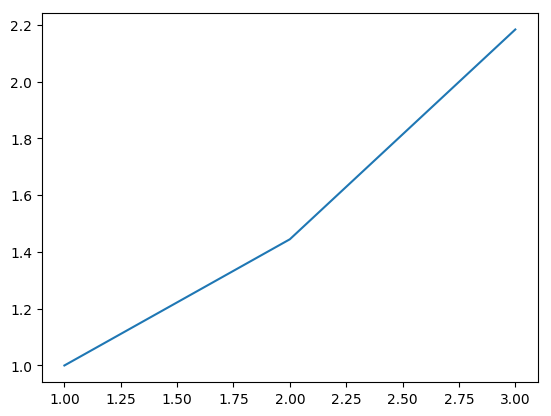

1.0, 1.44456, 2.18357]


In [10]:
using JuMP, Gurobi, PyPlot, Cbc

#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        # task, worker values
        # task, worker values
        N = rand(15:20,1,3)
        W = 5*u
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Binary Task Bundles - Tasks
number of workers and number of task types is constant

number of tasks scales


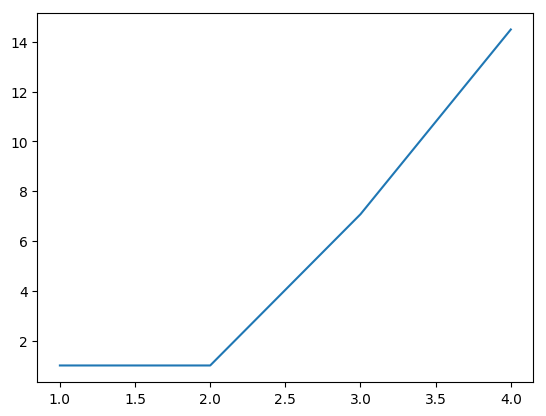

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Relative speed: [1.0, 0.999702, 7.0747, 14.4941]
Timer to solve: [0.0320187, 0.0320091, 0.226522, 0.464083]


In [14]:
using JuMP, Gurobi, PyPlot, Cbc

#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        # task, worker values
        # task, worker values
        N = rand(15:20,1,u)
        W = 5
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Binary Task Bundels - Task Type
Number of workers and total tasks are constant
Number of task types scales

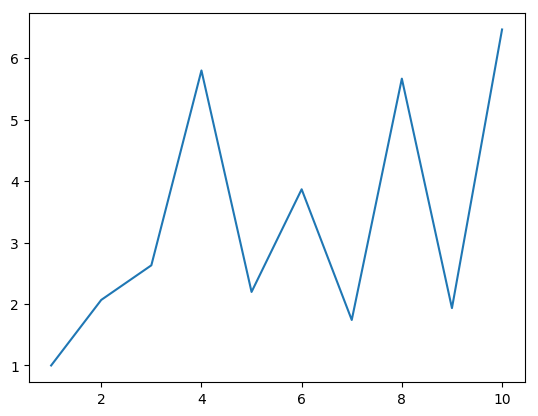

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Relative speed: [1.0, 2.06671, 2.6298, 5.80013, 2.1967, 3.86684, 1.74052, 5.66696, 1.93329, 6.46696]
Timer to solve: [0.0150394, 0.0310822, 0.0395508, 0.0872307, 0.0330372, 0.0581551, 0.0261765, 0.085228, 0.0290756, 0.0972595]


In [16]:
using JuMP, Gurobi, PyPlot, Cbc

#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        # task, worker values
        # task, worker values
        N = round.(Int, 50/u * ones(u))
        W = 5
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

## Binary Task Bundels - Tasks and Variety
Number of workers held constant
Number of tasks scales, and total quota scales

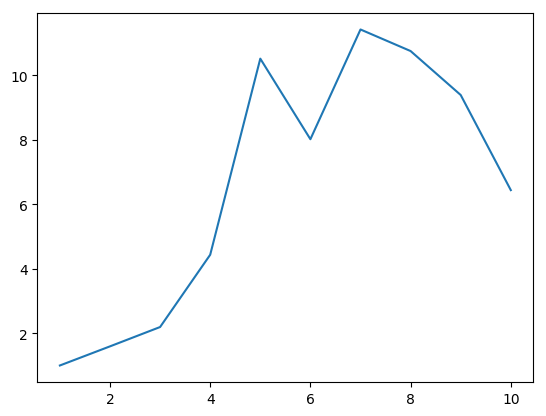

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Relative speed: [1.0, 1.59283, 2.19229, 4.43313, 10.5139, 8.

In [18]:
using JuMP, Gurobi, PyPlot, Cbc

#scaleFactor = 20
#averages = 5
timer = zeros(scaleFactor)

for p=1:averages
    for u=1:scaleFactor
        # task, worker values
        # task, worker values
        N = rand(8:12,1,u)
        W = 5
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)